In [5]:
import pandas as pd

df = pd.read_csv("incidentProcess_custom.csv")
#print(df.columns)
print(df.head())


C:\Users\Hari\AppData\Local\Temp\ipykernel_15076\992887487.py:3: DtypeWarning: Columns (19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("incidentProcess_custom.csv")


  Incident ID                     Activity ActivityTimeStamp Asset Affected  \
0   IM0000004  Assign to 2nd Line Operator           17:17.0      SUB000508   
1   IM0000004  Assign to 1st Line Operator           09:37.0      SUB000508   
2   IM0000004  Assign to 2nd Line Operator           09:38.0      SUB000508   
3   IM0000004  Assign to 1st Line Operator           41:30.0      SUB000508   
4   IM0000004  Assign to 2nd Line Operator           41:31.0      SUB000508   

  Asset Type Affected Asset SubType Affected Service Affected  Status  Impact  \
0      subapplication  Web Based Application       SRVC000162  Closed     4.0   
1      subapplication  Web Based Application       SRVC000162  Closed     4.0   
2      subapplication  Web Based Application       SRVC000162  Closed     4.0   
3      subapplication  Web Based Application       SRVC000162  Closed     4.0   
4      subapplication  Web Based Application       SRVC000162  Closed     4.0   

   Urgency  ...     Resolved Time     

In [4]:
for x in df.columns:
    print(f"'{x}': {{'type': 'string', 'description': '{x}'}},")

print(len(df.columns))


'Incident ID': {'type': 'string', 'description': 'Incident ID'},
'Activity': {'type': 'string', 'description': 'Activity'},
'ActivityTimeStamp': {'type': 'string', 'description': 'ActivityTimeStamp'},
'Asset Affected': {'type': 'string', 'description': 'Asset Affected'},
'Asset Type Affected': {'type': 'string', 'description': 'Asset Type Affected'},
'Asset SubType Affected': {'type': 'string', 'description': 'Asset SubType Affected'},
'Service Affected': {'type': 'string', 'description': 'Service Affected'},
'Status': {'type': 'string', 'description': 'Status'},
'Impact': {'type': 'string', 'description': 'Impact'},
'Urgency': {'type': 'string', 'description': 'Urgency'},
'Priority': {'type': 'string', 'description': 'Priority'},
'Category': {'type': 'string', 'description': 'Category'},
'Number of Reassignments': {'type': 'string', 'description': 'Number of Reassignments'},
'Open Time': {'type': 'string', 'description': 'Open Time'},
'Reopen Time': {'type': 'string', 'description': '

In [1]:
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.importer.xes import importer as xes_importer

# Load CSV
df = pd.read_csv("incidentProcess_custom.csv", dtype=str, low_memory=False)

# Keep only rows with valid Incident ID and Activity
df = df[df["Incident ID"].notna() & df["Activity"].notna()]

# Convert timestamps
df["ActivityTimeStamp"] = pd.to_datetime(df["ActivityTimeStamp"], errors="coerce")

# Drop rows with missing timestamps (optional, or fill with fallback timestamp)
df = df.dropna(subset=["ActivityTimeStamp"])

# Rename columns for PM4PY
df.rename(columns={
    "Incident ID": "case:concept:name",
    "Activity": "concept:name",
    "ActivityTimeStamp": "time:timestamp",
    "Assignment Group": "org:group"
}, inplace=True)

# Make sure all values are strings
df = df.astype(str)

# Convert timestamp column properly
df = dataframe_utils.convert_timestamp_columns_in_df(df)

# Convert to event log
from pm4py.objects.conversion.log import converter as log_converter
log = log_converter.apply(df)

# Extract and sort variant statistics
from pm4py.statistics.traces.generic.log import case_statistics
variants_count = case_statistics.get_variant_statistics(log)

# Sort safely using int for count
variants_count = sorted(variants_count, key=lambda x: (int(x["count"]), x["variant"]), reverse=True)

# Show top 5 variants
for variant in variants_count[:5]:
    print(f"Variant: {variant['variant']}, Count: {variant['count']}")


C:\Users\Hari\AppData\Local\Temp\ipykernel_37304\377508355.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["ActivityTimeStamp"] = pd.to_datetime(df["ActivityTimeStamp"], errors="coerce")


Variant: ('Open',), Count: 4507
Variant: ('Assign to 1st Line Operator',), Count: 2924
Variant: ('Open', 'Assign to 1st Line Operator'), Count: 2298
Variant: ('Close', 'Set Asset Caused'), Count: 2262
Variant: ('Set Asset Caused', 'Close'), Count: 1553


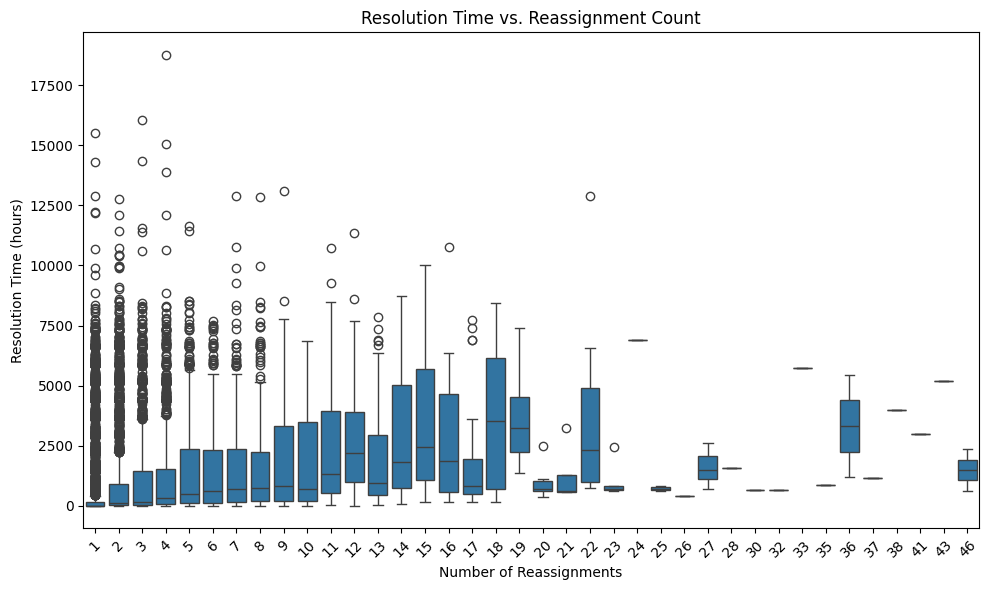

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Count reassignments per case (Incident ID)
# We'll define reassignment as any "Assign to ..." activity
df['IsReassignment'] = df['concept:name'].str.contains("Assign to", case=False)
reassign_counts = df[df['IsReassignment']].groupby('case:concept:name').size().reset_index(name='ReassignmentCount')

# Step 2: Get resolution time per case (in hours)
# Remove nulls and ensure numeric conversion
df['Resolved Time'] = pd.to_datetime(df['Resolved Time'], errors='coerce')
df['Open Time'] = pd.to_datetime(df['Open Time'], errors='coerce')
df['ResolutionTimeHours'] = (df['Resolved Time'] - df['Open Time']).dt.total_seconds() / 3600

# Get one row per incident with resolution time
resolution_time = df.dropna(subset=['ResolutionTimeHours'])[['case:concept:name', 'ResolutionTimeHours']].drop_duplicates()

# Step 3: Merge both summaries
merged = pd.merge(reassign_counts, resolution_time, on='case:concept:name')
# Keep only rows with non-negative resolution time
merged = merged[merged['ResolutionTimeHours'] >= 0] # Ensure no negative resolution times
# Rename columns for clarity
merged = merged.rename(columns={'case:concept:name': 'Incident ID'})

# Step 4: Visualize using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='ReassignmentCount', y='ResolutionTimeHours', data=merged)
plt.title('Resolution Time vs. Reassignment Count')
plt.xlabel('Number of Reassignments')
plt.ylabel('Resolution Time (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
